In [1]:
import xarray as xr
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pyproj import Proj, Geod
from dateutil.parser import parse as parse_date

#### Testing GOES Patches

In [19]:
# Taken from: tobac_flow/abi.py --> written by Will Jones

def get_abi_proj(dataset: xr.Dataset) -> Proj:
    """
    Return a pyproj projection from the information contained within an ABI file
    """
    return Proj(
        proj="geos",
        h=dataset.goes_imager_projection.perspective_point_height,
        lon_0=dataset.goes_imager_projection.longitude_of_projection_origin,
        lat_0=dataset.goes_imager_projection.latitude_of_projection_origin,
        sweep=dataset.goes_imager_projection.sweep_angle_axis,
    )

def get_abi_lat_lon(
    dataset: xr.Dataset, dtype: type = float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns latitude and longitude for each location in an ABI dataset
    """
    p = get_abi_proj(dataset)
    xx, yy = np.meshgrid(
        (
            dataset.x.data * dataset.goes_imager_projection.perspective_point_height
        ).astype(dtype),
        (
            dataset.y.data * dataset.goes_imager_projection.perspective_point_height
        ).astype(dtype),
    )
    lons, lats = p(xx, yy, inverse=True)
    lons[lons >= 1e30] = np.nan
    lats[lats >= 1e30] = np.nan
    return lats, lons

def get_abi_zenith_angle(abi_ds):
    """
    Returns the satellite zenith angle for every pixel in the input dataset
    """
    lat, lon = get_abi_lat_lon(abi_ds)
    dlat = np.deg2rad(lat - abi_ds.goes_imager_projection.latitude_of_projection_origin)
    dlon = np.deg2rad(
        lon - abi_ds.goes_imager_projection.longitude_of_projection_origin
    )

    surf_vectors = np.stack(
        [np.cos(dlon) * np.sin(dlat), -np.sin(dlon), np.cos(dlon) * np.cos(dlat)]
    )
    xx, yy = np.meshgrid(-abi_ds.x, -abi_ds.y)

    abi_vectors = np.stack(
        [np.cos(xx) * np.sin(yy), -np.sin(xx), np.cos(xx) * np.cos(yy)]
    )

    sza = np.rad2deg(np.arccos(np.sum(surf_vectors * abi_vectors, 0)))

    return sza

In [27]:
# test loading a GOES patch

goes_path = '/home/anna.jungbluth/2025-esl-3dclouds-extremes-datasets/pre-training/goes/mcmip/20180103011539_patch_1719_50.nc'
goes_patch = xr.open_dataset(goes_path)

In [28]:
goes_patch.x

<xarray.DataArray 'x' (x: 1024)> Size: 4kB
array([-0.05558 , -0.055524, -0.055468, ...,  0.001596,  0.001652,  0.001708],
      shape=(1024,), dtype=float32)
Coordinates:
    t        datetime64[ns] 8B ...
  * x        (x) float32 4kB -0.05558 -0.05552 -0.05547 ... 0.001652 0.001708
    y_image  float32 4B ...
    x_image  float32 4B ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

In [ ]:
# GOES doesn't natively come with lat/lon coordinates, so we need to calculate them:
lats, lons = get_abi_lat_lon(goes_patch)
# add to dataset:
goes_patch = goes_patch.assign_coords({"latitude": (("y", "x"), lats), "longitude": (("y", "x"), lons)})

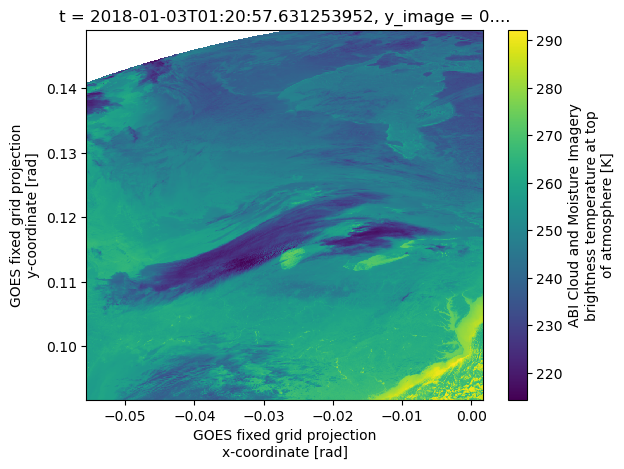

In [18]:
goes_patch.CMI_C14.plot()

In [21]:
# Get GOES zenith angle
zenith = get_abi_zenith_angle(goes_patch)

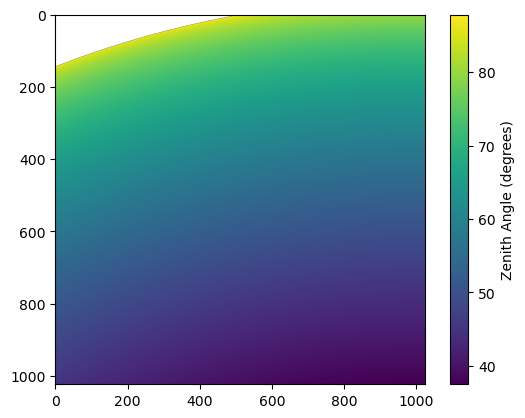

In [25]:
plt.imshow(zenith, cmap='viridis')
plt.colorbar(label='Zenith Angle (degrees)')

#### Testing MSG Patches

In [19]:
# test loading a MSG patch

msg_path = '/home/anna.jungbluth/2025-esl-3dclouds-extremes-datasets/pre-training/msg/l1b/20040127032735_patch_2046_2139.nc'
msg_patch = xr.open_dataset(msg_path)

In [20]:
msg_patch

<xarray.Dataset> Size: 55MB
Dimensions:             (y: 1024, x: 1024)
Coordinates:
  * y                   (y) float32 4kB 8.506e+05 8.536e+05 ... 3.92e+06
  * x                   (x) float32 4kB -5.716e+05 -5.746e+05 ... -3.641e+06
    longitude           (y, x) float32 4MB ...
    latitude            (y, x) float32 4MB ...
Data variables:
    msg_seviri_fes_3km  float32 4B ...
    IR_016              (y, x) float32 4MB ...
    IR_039              (y, x) float32 4MB ...
    IR_087              (y, x) float32 4MB ...
    IR_097              (y, x) float32 4MB ...
    IR_108              (y, x) float32 4MB ...
    IR_120              (y, x) float32 4MB ...
    IR_134              (y, x) float32 4MB ...
    VIS006              (y, x) float32 4MB ...
    VIS008              (y, x) float32 4MB ...
    WV_062              (y, x) float32 4MB ...
    WV_073              (y, x) float32 4MB ...
Attributes:
    history:      Created by pytroll/satpy on 2025-07-07 15:29:39.087613+00:00
    Conventions:  CF-1.7

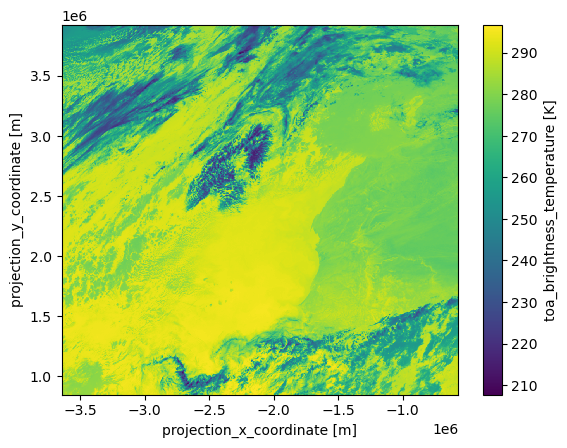

In [26]:
msg_patch.IR_108.plot()

In [30]:
msg_patch.x

<xarray.DataArray 'x' (x: 1024)> Size: 4kB
array([ -571576.9,  -574577.3,  -577577.7, ..., -3634988.5, -3637988.8,
       -3640989.2], shape=(1024,), dtype=float32)
Coordinates:
  * x        (x) float32 4kB -5.716e+05 -5.746e+05 ... -3.638e+06 -3.641e+06
Attributes:
    units:          m
    standard_name:  projection_x_coordinate

In [29]:
msg_patch.msg_seviri_fes_3km

<xarray.DataArray 'msg_seviri_fes_3km' ()> Size: 4B
[1 values with dtype=float32]
Attributes: (12/18)
    crs_wkt:                         PROJCRS["unknown",BASEGEOGCRS["unknown",...
    false_easting:                   0.0
    false_northing:                  0.0
    geographic_crs_name:             unknown
    grid_mapping_name:               geostationary
    horizontal_datum_name:           unknown
    ...                              ...
    prime_meridian_name:             Greenwich
    projected_crs_name:              unknown
    reference_ellipsoid_name:        unknown
    semi_major_axis:                 6378169.0
    semi_minor_axis:                 6356583.800000001
    sweep_angle_axis:                y

In [31]:
def get_seviri_zenith_angle(seviri_ds):
    """
    Returns the satellite zenith angle for every pixel in the input dataset
    """
    lat, lon = seviri_ds.latitude, seviri_ds.longitude
    dlat = np.deg2rad(lat - seviri_ds.msg_seviri_fes_3km.latitude_of_projection_origin)
    dlon = np.deg2rad(
        lon - seviri_ds.msg_seviri_fes_3km.longitude_of_projection_origin
    )
    surf_vectors = np.stack(
        [np.cos(dlon) * np.sin(dlat), -np.sin(dlon), np.cos(dlon) * np.cos(dlat)]
    )

    # Convert x and y from meters into radians

    x = seviri_ds.x / seviri_ds.msg_seviri_fes_3km.perspective_point_height
    y = seviri_ds.y / seviri_ds.msg_seviri_fes_3km.perspective_point_height

    xx, yy = np.meshgrid(-x, -y)

    seviri_vectors = np.stack(
        [np.cos(xx) * np.sin(yy), -np.sin(xx), np.cos(xx) * np.cos(yy)]
    )
    sza = np.rad2deg(np.arccos(np.sum(surf_vectors * seviri_vectors, 0)))

    return sza

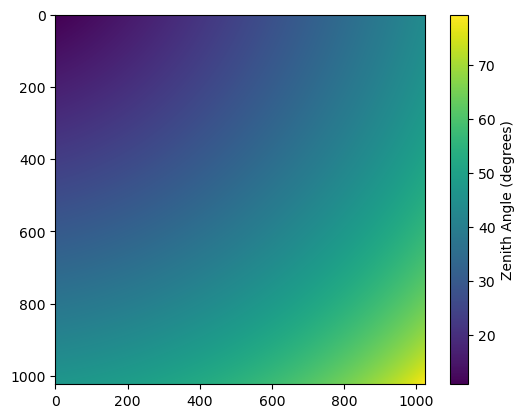

In [32]:
zenith = get_seviri_zenith_angle(msg_patch)
plt.imshow(zenith, cmap='viridis')
plt.colorbar(label='Zenith Angle (degrees)')

#### Testing HIMAWARI Patches

In [4]:
ds = xr.open_dataset('20210128132000_patch_2150_2389.nc', engine='netcdf4')

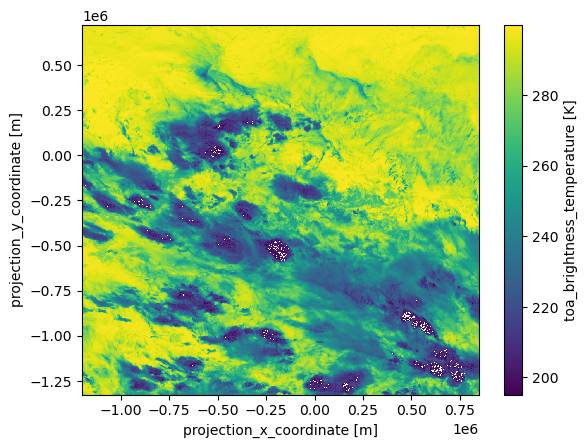

In [24]:
ds.B07.plot()

In [65]:
data_path = '/home/anna.jungbluth/data/himawari/himawari-42'
list_files = os.listdir(data_path)
list_files = [os.path.join(data_path, f) for f in list_files if f.endswith('.nc')]

In [66]:
num = np.random.randint(0, len(list_files))

ds = xr.open_dataset(list_files[num], engine='netcdf4')

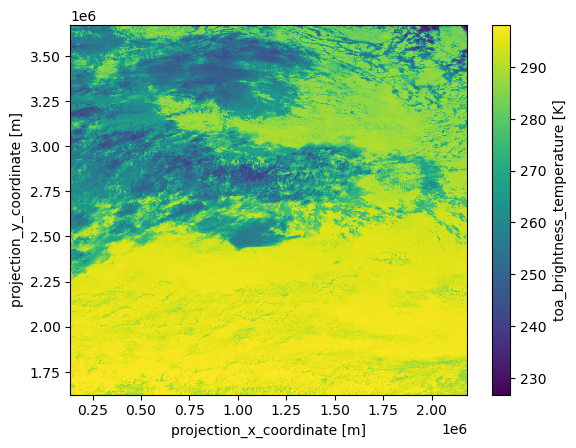

In [67]:
ds.B07.plot()

In [68]:
np.count_nonzero(np.isnan(ds.B07.data))/(ds.x.size * ds.y.size)

0.0

In [69]:
def check_quality_flags_himawari(ds, min_valid_fraction=0.999):
    """
    Function to check quality in HIMAWARI data.

    Args:
        ds (xarray.Dataset): The dataset to check.
        min_valid_fraction (float): Minimum fraction of valid data required for the dataset to pass the quality check.
            From experimentation, patches around the limb might have around 8000 to 10000 NaN values close to the disk edge
            even if the data on disk is valid. To not filter out all edge disk images, we emperically set the default to allow 1% of the data to be NaN.
    Returns:
        bool: True if the dataset passes the quality check, False otherwise.
    """
    channels=[
            'B01',
            'B02',
            'B03',
            'B04',
            'B05',
            'B06',
            'B07',
            'B08',
            'B09',
            'B10',
            'B11',
            'B12',
            'B13',
            'B14',
            'B15',
            'B16',]
    # create a mask where the latitude value is inf
    mask_lat = ~np.isinf(ds.latitude)
    mask_lon = ~np.isinf(ds.longitude)
    # combine both masks to find all points with valid lat/lon values
    mask = mask_lat & mask_lon
    # loop through each channel to check for NaN values
    for channel in channels:
        # Check for NaN only where mask is True, i.e. where the lat/lon values are valid
        nan_in_valid_region = np.isnan(ds[channel].values[mask])

        # If the fraction of NaN values in the valid region exceeds the threshold, return False
        if np.count_nonzero(nan_in_valid_region)/(ds.x.size * ds.y.size) > (1-min_valid_fraction):
            print(f"Channel {channel} did not pass the quality check with {np.count_nonzero(nan_in_valid_region)/(ds.x.size * ds.y.size)} NaN fraction.")        
        else: 
            print(f"Channel {channel} passed the quality check with {np.count_nonzero(nan_in_valid_region)/(ds.x.size * ds.y.size)} NaN fraction.")

In [70]:
check_quality_flags_himawari(ds)

Channel B01 passed the quality check with 0.0 NaN fraction.
Channel B02 passed the quality check with 0.0 NaN fraction.
Channel B03 passed the quality check with 0.0 NaN fraction.
Channel B04 passed the quality check with 0.0 NaN fraction.
Channel B05 passed the quality check with 0.0 NaN fraction.
Channel B06 passed the quality check with 0.0 NaN fraction.
Channel B07 passed the quality check with 0.0 NaN fraction.
Channel B08 passed the quality check with 0.0 NaN fraction.
Channel B09 passed the quality check with 0.0 NaN fraction.
Channel B10 passed the quality check with 0.0 NaN fraction.
Channel B11 passed the quality check with 0.0 NaN fraction.
Channel B12 passed the quality check with 0.0 NaN fraction.
Channel B13 passed the quality check with 0.0 NaN fraction.
Channel B14 passed the quality check with 0.0 NaN fraction.
Channel B15 passed the quality check with 0.0 NaN fraction.
Channel B16 passed the quality check with 0.0 NaN fraction.
